In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## **학습 & 테스트 프로세스 요약**
| 단계 | 학습 (Train) | 테스트 (Test) |
|------|------------|-------------|
| **1. 데이터 입력** | CSV 파일 (이미 추출된 특징값) | 동영상 |
| **2. 특징 추출** | CSV에서 불러오기 | 동영상 → 프레임 추출 → 12개 묶음 → 특징 추출 |
| **3. 데이터 변환** | `(배치, 12, 5)` 형태로 변환 | `(1, 12, 5)` 형태로 변환 |
| **4. 모델 학습/예측** | LSTM 모델 학습 | LSTM 모델을 이용해 예측 |
| **5. 결과 저장** | `.pth` 파일로 저장 | 예측값 출력 |


# 1. 학습

1. 추출된 feature 로드
2. LSTM Input 형식으로 변환
3. LSTM 학습

## 라이브러리 임포트

In [ ]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import random

import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from PIL import Image

from dataclasses import dataclass, field
from typing import Tuple, List

import warnings
warnings.filterwarnings('ignore')

from enum import Enum

class ModelType(Enum):
  BEST = "best"
  LAST = "last"

class DataType(Enum):
  TRAIN = "train"
  VAL = "val"
  TEST = "test"

base_dir = "/content/drive/MyDrive/DMS"


## 1-2. LSTM Input 형식으로 변환

### Config 설정

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    case_name: str = "bi-lstm_attention_long_window_24" # 바꿔야하는 부분

    # 모델 구조
    lstm_num_layers: int = 3
    lstm_hidden_size: int = 512
    fc_hidden_size: int = 256
    dropout_rate: float = 0.2 # input-to-hidden (between layers)
    bidirectional: bool = True

    # 학습 설정
    batch_size: int = 32
    epochs: int = 100
    learning_rate: float = 3e-4
    optimizer: str = "adam" # or "sgd", "adamw"

    # 입력 데이터(수정한 부분)
    sequence_length: int = 24
    sliding_window_step: int = 24 # sliding window 사용 x -> seuqnce_length와 같은 값으로 설정
    features: list = field(default_factory=lambda: ["mar", "ear", "yaw", "pitch", "phone_detected"])
    labels: list = field(default_factory=lambda: ["normal", "phonecall", "text", "yawn"])

    apply_yaw_inversion: bool = False
    apply_noise_jittering: bool = False

    # 학습 제어 - 조기 종료 / 러닝레이트 스케줄러
    use_early_stopping: bool = False  # 조기 종료 사용 여부
    use_lr_scheduler: bool = False    # 학습률 스케줄러 사용 여부
    early_stopping_patience: int = 20 # early stopping 기준 epoch
    reduce_lr_factor: float = 0.5 # learning rate 감소 비율
    reduce_lr_patience: int = 7 # learning rate 감소 기준 epoch

    # 랜덤시드 설정
    random_seed: int = 24

    def __post_init__(self):
      self.results_save_path = f"{base_dir}/runs/{self.case_name}"
      self.model_save_path = f"{self.results_save_path}/weights"

      os.makedirs(self.results_save_path, exist_ok=True)
      os.makedirs(self.model_save_path, exist_ok=True)

      if self.sequence_length == 12:
        df_path = f'{base_dir}/data/splits/12frame_windows'
        self.group_col = 'groups_12'
      elif self.sequence_length == 24:
        df_path = f'{base_dir}/data/splits/24frame_windows'
        self.group_col = 'groups_24'

      self.train = pd.read_csv(os.path.join(df_path, "final_train.csv"))
      self.validation = pd.read_csv(os.path.join(df_path, "final_val.csv"))
      self.test = pd.read_csv(os.path.join(df_path, "final_test.csv"))

      # label_mapping
      self.label_encoding = {}
      self.label_decoding = {}
      for i, label in enumerate(self.labels):
          self.label_encoding[label] = i # 문자열 라벨 : 숫자 인덱스
          self.label_decoding[i] = label # 숫자 인덱스 : 문자열 라벨

      # 디바이스 설정
      self.use_cuda = torch.cuda.is_available()
      self.device = torch.device("cuda" if self.use_cuda else "cpu")

cfg = Config()
# print(cfg.case_name) # 사용 예시

In [ ]:
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 연산에 대한 시드 설정
    torch.cuda.manual_seed(seed)  # CUDA 연산에 대한 시드 설정 (GPU 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용하는 경우 모든 GPU에 동일한 시드 설정
    np.random.seed(seed)  # NumPy 연산에 대한 시드 설정
    random.seed(seed)  # Python 기본 random 모듈의 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN 연산의 결정론적 동작 보장
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화 (재현성 보장)

set_random_seed(cfg.random_seed)

### 데이터 로드

### train, val, test 데이터셋 로드

In [ ]:
train_df = cfg.train.copy()
val_df = cfg.validation.copy()
test_df = cfg.test.copy()

In [ ]:
# train normal undersampling
train_df = train_df[((train_df['label'] == 'normal') &
                    (train_df[cfg.group_col].isin([1, 2]))) | # sequence_length에 따라 group_col이 설정됨 -> 파일 로드 -> group_col로 정의된 groups_12 열 가져오기
                    (train_df['label'] != 'normal')]

### generate_sequence_dataset

In [ ]:
def generate_sequence_dataset(
    df: pd.DataFrame
) -> Tuple[np.ndarray, np.ndarray, List[Tuple]]: # 가독성을 위해 변환 타입 명시. 작동x
    sequences, labels, metadata = [], [], []

    for (label, clip_id), clip_df in df.groupby(['label', 'clip_id']):
        clip_df = clip_df.sort_values('frame_no')
        frame_values = clip_df[cfg.features].values #(프레임 수, 변수 수)

        if len(frame_values) < cfg.sequence_length:
            continue

        for i in range(0, len(frame_values) - cfg.sequence_length + 1, cfg.sliding_window_step): # 전체 120, 슬라이딩 윈도우 12라면 (0, 109, 12)로 잘 들어간다
            seq = frame_values[i:i + cfg.sequence_length]
            if seq.shape[0] == cfg.sequence_length:
                sequences.append(seq)
                labels.append(cfg.label_encoding[label])
                # 학습 후 오분류 데이터 확인을 위한 시작 프레임 번호 저장
                metadata.append((label, clip_id, clip_df.iloc[i]['frame_no']))

    return TensorDataset(torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)), metadata

### DataLoader

In [ ]:
train_params = {
    "batch_size": cfg.batch_size,
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": cfg.use_cuda,
    "persistent_workers": cfg.use_cuda,
    "prefetch_factor": 2 if cfg.use_cuda else None,
}

test_params = {
    "batch_size": cfg.batch_size,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": cfg.use_cuda
}

In [ ]:
# DataLoader 생성 (배치 단위로 데이터를 나누기 위해 사용)
train_dataset, train_metadata = generate_sequence_dataset(train_df)
val_dataset, val_metadata = generate_sequence_dataset(val_df)
test_dataset, test_metadata = generate_sequence_dataset(test_df)

train_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **test_params)
test_loader = DataLoader(test_dataset, **test_params)

# 배치 단위 확인
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in val_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])


## 1-3. 모델 로드

### 모델 준비 함수

In [ ]:
# 모델 준비
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: [B, T, H]
        score = torch.tanh(self.attn(lstm_output))         # [B, T, H]
        attn_weights = torch.softmax(self.context(score), dim=1)  # [B, T, 1]
        attended_output = torch.sum(attn_weights * lstm_output, dim=1)  # [B, H]
        return attended_output, attn_weights  # context vector, weights

In [ ]:
# LSTM 모델 정의
class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = len(cfg.features)
        self.h_RNN_layers = cfg.lstm_num_layers
        self.h_RNN = cfg.lstm_hidden_size
        self.h_FC_dim = cfg.fc_hidden_size
        self.drop_p = cfg.dropout_rate
        self.num_classes = len(cfg.labels)
        self.bidirectional = cfg.bidirectional

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )

        lstm_output_dim = self.h_RNN * (2 if self.bidirectional else 1)

        self.attention = Attention(lstm_output_dim) # Attention 추가
        self.fc1 = nn.Linear(lstm_output_dim, self.h_FC_dim)
        self.bn1 = nn.BatchNorm1d(self.h_FC_dim)  # Batch Normalization 추가
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        out, _ = self.LSTM(x_RNN)  # (batch, seq_len, hidden*2)

        attn_out, attn_weights = self.attention(out)  # attn_out: [B, H]

        # FC layers
        x = self.fc1(attn_out)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x, attn_weights  # CrossEntropyLoss 사용 (Softmax 없음), attn_weights 함께 반환

### 모델 로드 함수

In [ ]:
# 모델 로드 함수
def load_model(model, device, model_type=ModelType.BEST):
    """저장된 모델을 불러오는 함수"""
    model_path = os.path.join(cfg.model_save_path, f"{model_type.value}_model.pth")
    checkpoint = torch.load(model_path, map_location=device)
    #torch.save로 저장된 모델은 모델 가중치만 저장되어 있어 미리 모델 구조를 정의해줘야 한다
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_path}")
    return model

### 예측값 출력 함수

In [ ]:
# 모든 입력값, 라벨값, 예측값, 확률값을 구함
def get_preds_and_labels(model, device, data_loader, print_sample=False, max_print=10):
    model.eval()
    all_inputs = []
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader: # 전부 읽기
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            logits = model(x_batch)
            if isinstance(logits, tuple):
                logits = logits[0]

            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_inputs.extend(x_batch.cpu())
            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # 옵션: 일부 샘플의 실제값 vs 예측값 출력
    if print_sample:
        print("=== Sample Predictions ===")
        for i in range(min(max_print, len(all_labels))):
            print(f"[{i}] True: {all_labels[i]} | Pred: {all_preds[i]} | Prob: {all_probs[i]}")

    return (
        torch.stack(all_inputs),          # shape: [N, T, F] or [N, ...]
        np.array(all_labels),             # shape: [N]
        np.array(all_preds),              # shape: [N]
        np.array(all_probs),              # shape: [N, num_classes]
    )


### 실행

In [ ]:
model = DecoderRNN()
model.to(cfg.device)

model = load_model(model, cfg.device) # best model load

✅ Model Loaded from /content/drive/MyDrive/DMS/runs/bi-lstm_attention_long_window_24/weights/best_model.pth


In [ ]:
all_train_inputs, all_train_labels, all_train_preds, all_train_probs = get_preds_and_labels(model, cfg.device, train_loader)
all_val_inputs, all_val_labels, all_val_preds, all_val_probs = get_preds_and_labels(model, cfg.device, val_loader)
all_test_inputs, all_test_labels, all_test_preds, all_test_probs = get_preds_and_labels(model, cfg.device, test_loader)

# 2. 해석 기법 도입

'''
목표 : 특성들을 사용해 어떻게 예측하는지 확인
1. 어텐션, shap, ig는 원래 개별 샘플에 적용하는 것인데 전체적인 경향성을 보기 위해 전체 데이터에 적용한 후 평균값을 이용한다. 더불어 std값도 병기
2. 어텐션에서 타임스탭별 평균값을 구하고 나머지는 특성별 평균값만 다룬다
3. 라벨별로 특성이 어떻게 적용되어서 예측되는지가 핵심이기에 라벨별로 계산 후 시각화한다
4. 테스트셋에 대하여 실제 라벨을 기준으로 한다
5. ig, shap는 계산이 느리므로 배치를 사용한다
'''

## 2-0. 필요한 함수들

## 2-2. SHAP (pemutation으로 계산 -> clustering)

In [ ]:
import shap

In [ ]:
all_test_inputs.shape

torch.Size([989, 24, 5])

In [ ]:
# 1. 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

DecoderRNN(
  (LSTM): LSTM(5, 512, num_layers=3, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=1024, out_features=1024, bias=True)
    (context): Linear(in_features=1024, out_features=1, bias=False)
  )
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# 2. 평균값 계산 및 변환
X_test_mean = all_test_inputs.mean(dim=1)  # (989, 5)
X_test_mean_np = X_test_mean.cpu().numpy()

In [ ]:
# 3. 예측 함수 정의 (LSTM에 맞게 확장, GPU 사용, 튜플 처리 포함)
def model_predict(X_mean_input_np):
    X_tensor = torch.tensor(X_mean_input_np, dtype=torch.float32).to(device)
    X_repeated = X_tensor.unsqueeze(1).repeat(1, 24, 1)

    with torch.no_grad():
        preds = model(X_repeated)
        if isinstance(preds, tuple):
            preds = preds[0]

    return preds.detach().cpu().numpy()

In [ ]:
# 4. SHAP 계산
# 입력은 (샘플 수, 변수 수)
'''
explainer = shap.explainers.Permutation(model_predict, masker=X_test_mean_np, output_names=cfg.features)
shap_vals = explainer(X_test_mean_np)

import joblib
joblib.dump(shap_vals, "/content/drive/MyDrive/DMS/runs/shap_results/shap_values.pkl")
print("SHAP 값 저장 완료: shap_values.pkl")
'''

'\nexplainer = shap.explainers.Permutation(model_predict, masker=X_test_mean_np, output_names=cfg.features)\nshap_vals = explainer(X_test_mean_np)\n\nimport joblib\njoblib.dump(shap_vals, "/content/drive/MyDrive/DMS/runs/shap_results/shap_values.pkl")\nprint("SHAP 값 저장 완료: shap_values.pkl")\n'

#### 결과 로드 및 시각화

In [ ]:
import joblib

In [ ]:
shap_vals = joblib.load("/content/drive/MyDrive/DMS/runs/shap_results/shap_values.pkl")
print("SHAP 값 불러오기 완료")

SHAP 값 불러오기 완료


In [ ]:
print(type(shap_vals))
'''print(shap_vals.values if hasattr(shap_vals, "values") else shap_vals)'''
print(shap_vals[0])

<class 'shap._explanation.Explanation'>
.values =
array([[ 0.17605667, -0.08536709,  0.44956669, -0.76016782],
       [-0.36702202,  0.46881513,  0.05106992,  0.55378781],
       [-0.17712616,  0.66265134, -0.17595514,  0.99838811],
       [-0.86367514,  0.13957071,  1.21062788,  0.31720147],
       [ 1.99519652, -3.88304912,  0.27410699,  0.91521205]])

.base_values =
array([ 1.5698638 , -5.39769562, -2.41326235, -4.94205325])

.data =
array([ 0.00485876,  0.08721659, -0.4750521 , -0.09602064,  0.        ],
      dtype=float32)


In [ ]:
shap_vals.shape # 샘플 수, 피쳐 수, 클래스 수

(989, 5, 4)

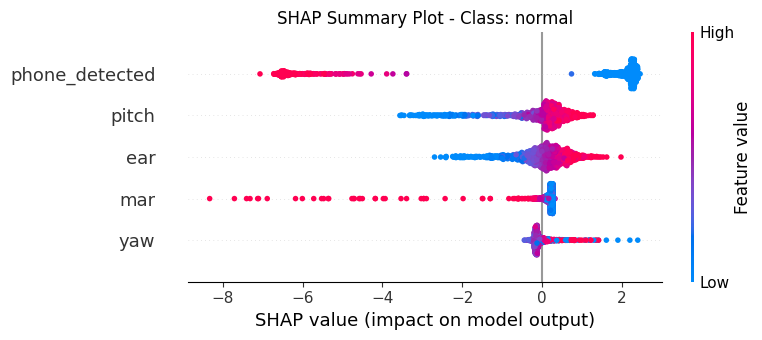

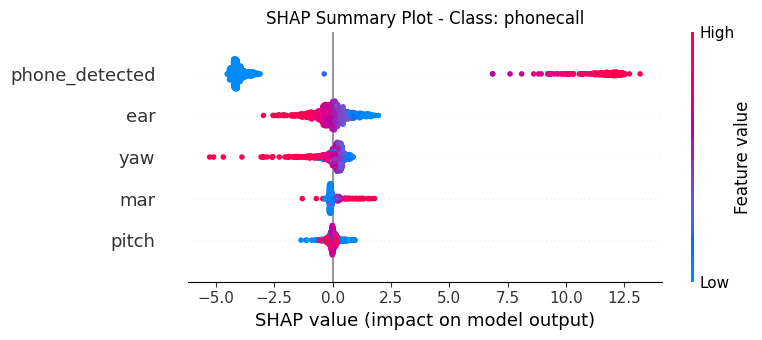

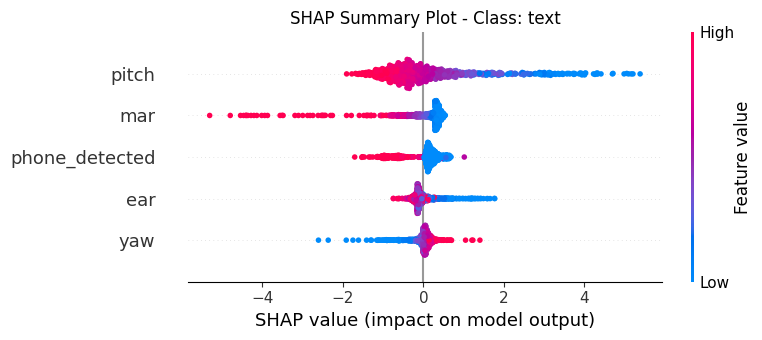

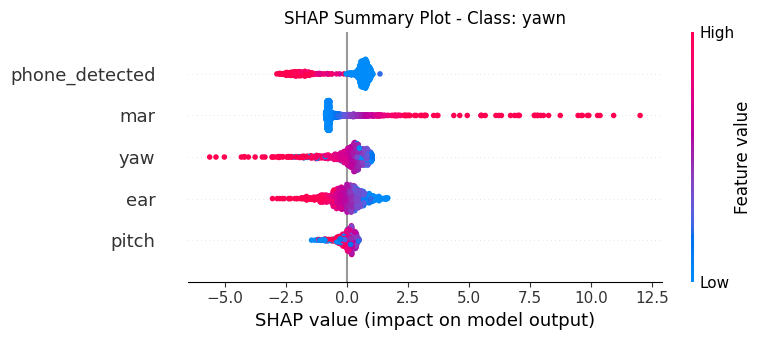

In [ ]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.figure()  # 새로운 figure 생성
    shap.summary_plot(
        shap_vals[:, :, i],
        X_test_mean_np,
        feature_names=cfg.features,
        show=False
    )
    # shap_vals[:, :, i]는 하나의 클래스에 대한 피처별 shap값
    # X_test_mean_np는 각 샘플의 실제 입력값
    plt.title(f"SHAP Summary Plot - Class: {cfg.labels[i]}")
    plt.tight_layout()
    plt.show()


'''
output_names를 cfg.labels로 지정했기 때문에 이 순서와 shap_vals의 클래스 차원 순서가 동일
summary plot에 들어가는 feature matrix와 feature_names가 같은 순서와 개수를 가지므로, 그래프 축 라벨도 정확히 매칭\

가로축 : shap값. 각 피쳐가 클래스의 '예측'에 얼마나 기여했는지 보여줌(실제값 아님). 0값을 기준으로 양수면 가능성을 예측을 올려주고 음수면 낮춤
세로축 : 각 피쳐. 중요도가 높은 순서대로 내림차순 배치됨
점 : 하나의 샘플에 대한 각 피쳐의 shap값. 하나의 샘플은 모든 피쳐축에 점을 하나씩 찍는다
점의 색상 : 해당 피쳐에 대한 실제값. 실제값은 실제 피쳐들의 데이터를 말한다. 파란색이면 낮고, 빨간색이면 크다

shap 패턴 해석 방법
1. 특정 피쳐가 한쪽 방향으로만 분포됨 : 해당 피쳐가 이 클래스를 예측하는데 크게 기여
2. 점 색상 구분이 뚜렷함 : 빨간색과 파란색이 오른쪽 혹은 왼쪽으로 명확히 구분되어 분포됨
3. 클러스터의 구분이 뚜렷함 : 점들이 명확하게 분리되어 있으면 해당 피쳐의 영향력 강함
'''